# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Normalizer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from collections import Counter

## 1.1 Loading Data

In [2]:
import pandas
data = pandas.read_csv('preprocessed_data.csv',nrows = 50000)

In [3]:
print("Shape of the Dataset :{0}".format(data.shape))

Shape of the Dataset :(50000, 9)


In [4]:
print(data.columns)

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')


AxesSubplot(0.125,0.27;0.775x0.465)


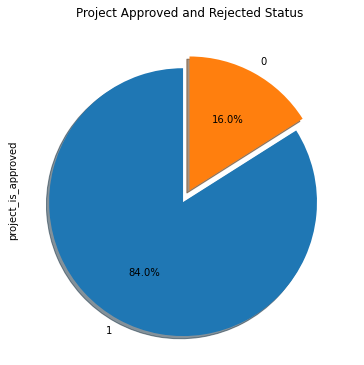

In [5]:
#Count of Project is approved
plt.figure(figsize = (6,10))
print(data.project_is_approved.value_counts().plot.pie(explode = [0.1,0],startangle = 90, shadow = True,autopct = "%1.1f%%"))
plt.title("Project Approved and Rejected Status")
plt.show()

In [6]:
#Preprocess Data
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [7]:
#remove the word length < 2 and remove the stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


def stop_word_removal(sentence):
    cleaned_words = []
    for word in sentence.split():
        
        if len(word) >=2 and word not in stop_words:
            
            cleaned_words.append(word)
    return " ".join(cleaned_words)


In [8]:
data_essay = data.essay.tolist()
cleaned_sentence = []
for sentence in data_essay:
    cleaned_sentence.append(stop_word_removal(sentence))



In [9]:
data.essay = np.array(cleaned_sentence)

In [10]:
#Independent feature
X = data.drop(columns = ['project_is_approved'])
#target feature or output feature
y = data.loc[:,'project_is_approved']
print("Shape of  X: {0} and Y : {1}".format(X.shape,y.shape))

Shape of  X: (50000, 8) and Y : (50000,)


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [11]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

#Split the data as train and test 
X_train,x_test,Y_train,y_test = train_test_split(X,y,test_size = 0.1,stratify=y)
x_train_final,x_cv,Y_train_final,y_cv = train_test_split(X_train,Y_train,test_size = 0.1,stratify = Y_train)

print("Shape Of the training Data :{0}".format(x_train_final.shape))
print("Shape of the Validation Data : {0}".format(x_cv.shape))
print("Shape of the Test Data : {0}".format(x_test.shape))

Shape Of the training Data :(40500, 8)
Shape of the Validation Data : (4500, 8)
Shape of the Test Data : (5000, 8)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [12]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
#Bag of Word for CategoriacalData

In [13]:
#Store all the Feature Name in the List
feature_name_List = []

vectorizer = CountVectorizer(max_features = 7000).fit(x_train_final.essay.values)
#extend all the essay featureName
feature_name_List.extend(vectorizer.get_feature_names())
X_train_essay_bow = vectorizer.transform(x_train_final.essay.values)
x_cv_essay_bow = vectorizer.transform(x_cv.essay.values)
x_test_essay_bow = vectorizer.transform(x_test.essay.values)

In [14]:
print("After Vectorization Shape of the Essay Feature")
print("Shape of the training Essay Feature : {0}".format(X_train_essay_bow.shape))
print("Shape of the CV Essay Feature :{0}".format(x_cv_essay_bow.shape))
print("Shape of the Test Essay Feature : {0}".format(x_test_essay_bow.shape))

After Vectorization Shape of the Essay Feature
Shape of the training Essay Feature : (40500, 7000)
Shape of the CV Essay Feature :(4500, 7000)
Shape of the Test Essay Feature : (5000, 7000)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

#  Encoding Categorical Features

In [15]:
#Cateforiacal Encodinf gor TeacherPrefix Data
def categoricalEncoding(x_train,x_test,x_cv,col_name,feature_name_List):
    
    #param-1 -> training Data
    
    #param-2 -> test Data
    
    #param-3 -> validation Data 
    
    #param-4 -< feature Name -(column Name)
    
    #param-5 -> feature_name_list
    
    vectorizer = CountVectorizer()
    
    vectorizer.fit(x_train[col_name])
    
    feature_name_List.extend(vectorizer.get_feature_names())
    
    x_train_category = vectorizer.transform(x_train[col_name])
    
    x_test_category = vectorizer.transform(x_test[col_name])
    
    x_cv_category = vectorizer.transform(x_cv[col_name])
    
    
    print("After Transforming the Data Shape")
    
    print("Shape of the Training Feature Category : {0}".format(x_train_category.shape))
    
    print("Shape of the Test Feature Category : {0}".format(x_test_category.shape))
    
    print("Shape of the Validation Feature Category : {0}".format(x_cv_category.shape))
    
    return (x_train_category,x_test_category,x_cv_category)
    

In [16]:
#Encoding teacher_prefix category
print("Categorical Encoding for teacher_prefix Feature")
print('Categories of teacher_prefix : {0}'.format(x_train_final['teacher_prefix'].unique()))
X_train_teacher_prefix_category,x_test_teacher_prefix_category,x_cv_test_prefix_category \
= categoricalEncoding(x_train_final,x_test,x_cv,'teacher_prefix',feature_name_List)

print("--"* 60)
print("Categorical Encoding for Project_grade_category")
print('Categories of project_grade_category : {0}'.format(x_train_final['project_grade_category'].unique()))
X_train_project_grade_category,x_test_project_grade_category,x_cv_project_grade_category \
= categoricalEncoding(x_train_final,x_test,x_cv,'project_grade_category',feature_name_List)

print("--"* 60)
print('Categories of school_state : {0}'.format(x_train_final['school_state'].unique()))
print("Categorical Encoding for teacher_school_State category")
X_train_school_state,x_test_teacher_school_state,x_cv_school_state \
= categoricalEncoding(x_train_final,x_test,x_cv,'school_state',feature_name_List)

print("--"* 60)
print('Categories of clean_categories : {0}'.format(x_train_final['clean_categories'].nunique()))
print("Categorical Encoding for clean Project Subject Category")
X_train_clean_categories,x_test_clean_categories,x_cv_clean_categories \
= categoricalEncoding(x_train_final,x_test,x_cv,'clean_categories',feature_name_List)

print("--"* 60)
print('Categories of clean_subcategories : {0}'.format(x_train_final['clean_subcategories'].nunique()))
print("Categorical Encoding for Project Subject Sub Category")
X_train_clean_subcategories,x_test_clean_subcategories,x_cv_clean_subcategories \
= categoricalEncoding(x_train_final,x_test,x_cv,'clean_subcategories',feature_name_List)
 


Categorical Encoding for teacher_prefix Feature
Categories of teacher_prefix : ['mrs' 'ms' 'mr' 'teacher' 'dr']
After Transforming the Data Shape
Shape of the Training Feature Category : (40500, 5)
Shape of the Test Feature Category : (5000, 5)
Shape of the Validation Feature Category : (4500, 5)
------------------------------------------------------------------------------------------------------------------------
Categorical Encoding for Project_grade_category
Categories of project_grade_category : ['grades_prek_2' 'grades_3_5' 'grades_6_8' 'grades_9_12']
After Transforming the Data Shape
Shape of the Training Feature Category : (40500, 4)
Shape of the Test Feature Category : (5000, 4)
Shape of the Validation Feature Category : (4500, 4)
------------------------------------------------------------------------------------------------------------------------
Categories of school_state : ['md' 'ca' 'sd' 'oh' 'tx' 'in' 'al' 'fl' 'va' 'tn' 'ok' 'de' 'il' 'ma'
 'ia' 'mo' 'nc' 'mi' 'sc' 'ny

In [17]:


def NumericalEncoding(x_train,x_cv,X_test,column_name):
    
    train_norm = Normalizer()
    
    train_norm.fit(x_train[column_name].values.reshape(-1,1))
    
    x_train_norm_transform = train_norm.fit_transform(x_train[column_name].values.reshape(-1,1))
    
    x_cv_norm = train_norm.transform(x_cv[column_name].values.reshape(-1,1))
    
    x_test_norm = train_norm.transform(X_test[column_name].values.reshape(-1,1))
    
    print("After Transforming the Data Shape")
    
    print("Shape of the Training Feature Category : {0}".format(x_train_norm_transform.shape))
    
    print("Shape of the Test Feature Category : {0}".format(x_cv_norm.shape))
    
    print("Shape of the Validation Feature Category : {0}".format(x_test_norm.shape))
    
    return (x_train_norm_transform,x_cv_norm,x_test_norm)
    

In [18]:
#Numerical Feature Normalization
#X_train.price.values.reshape(-1,1)
#this Line Conver the One dimentional array to multiple dimentional Array

#Numerical Encoding for the feature Price 
print("Numerical Transformation for the Feature price")
x_train_price_norm,x_cv_price_norm,x_test_price_norm =NumericalEncoding(x_train_final,x_cv,x_test,'price')
feature_name_List.append("price")

print("="*70)
#Numerical Feature Transformation for the feature Previous Teacher Project
print("Numerical Transformation for the Feature teacher_number_of_previously_posted_projects")
x_train_previous_project_norm,x_cv_previous_project_norm,x_test_previous_project_norm =\
NumericalEncoding (x_train_final,x_cv,x_test,'teacher_number_of_previously_posted_projects')
feature_name_List.append("teacher_number_of_previously_posted_projects")


Numerical Transformation for the Feature price
After Transforming the Data Shape
Shape of the Training Feature Category : (40500, 1)
Shape of the Test Feature Category : (4500, 1)
Shape of the Validation Feature Category : (5000, 1)
Numerical Transformation for the Feature teacher_number_of_previously_posted_projects
After Transforming the Data Shape
Shape of the Training Feature Category : (40500, 1)
Shape of the Test Feature Category : (4500, 1)
Shape of the Validation Feature Category : (5000, 1)


# Concatinate Preprocessed Data 

In [19]:
from scipy.sparse import hstack

#Training Preprocessing Dataset
X_train_final_data = hstack((X_train_essay_bow, X_train_teacher_prefix_category, X_train_project_grade_category, \
               X_train_school_state, X_train_clean_categories,X_train_clean_subcategories,\
                 x_train_price_norm,x_train_previous_project_norm)).tocsr()


#Test Prprocessing final Dataset
X_test_final_data = hstack((x_test_essay_bow, x_test_teacher_prefix_category, x_test_project_grade_category, \
               x_test_teacher_school_state, x_test_clean_categories,x_test_clean_subcategories,\
                 x_test_price_norm,x_test_previous_project_norm)).tocsr()

#Cross Validation Preprocessing Dataset
X_cv_final_data = hstack((x_cv_essay_bow, x_cv_test_prefix_category, x_cv_project_grade_category, \
               x_cv_school_state, x_cv_clean_categories,x_cv_clean_subcategories,\
                 x_cv_price_norm,x_cv_previous_project_norm)).tocsr()

print("="*100)
print("Ater Encoding and Transforming Numerical and Categorical Features")
print(X_train_final_data.shape, Y_train_final.shape)
print(X_test_final_data.shape, y_test.shape)
print(X_cv_final_data.shape, y_cv.shape)


Ater Encoding and Transforming Numerical and Categorical Features
(40500, 7101) (40500,)
(5000, 7101) (5000,)
(4500, 7101) (4500,)



<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [20]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [21]:
def batchPredict(model,data):
    y_predict_list = []
    
    dataLoop = data.shape[0] - (data.shape[0] %1000)
    
    for i in range(0, dataLoop, 1000):
        y_predict_list.extend(model.predict_proba(data[i:i+1000])[:,1])
    
    #predict remainng data
    
    if data.shape[0] % 1000 != 0:
        y_predict_list.extend(model.predict_proba(data[dataLoop:])[:,1])
    
    return y_predict_list
    

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.59it/s]


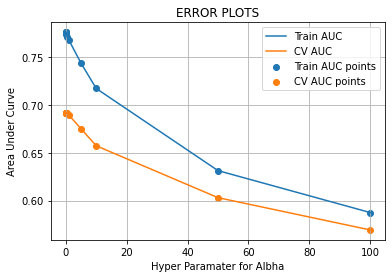

In [22]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

train_score = []
crossValidation_Score = []
train_auc,cv_auc = [],[]
#hyper param tuning 
alphaList =  [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
class_weight = [0.5,0.5]
for alpha in tqdm(alphaList):
    naive_bag_of_words = MultinomialNB(alpha=alpha,class_prior = class_weight)
    naive_bag_of_words.fit(X_train_final_data, Y_train_final)

    y_train_pred = batchPredict(naive_bag_of_words, X_train_final_data)    
    y_cv_pred = batchPredict(naive_bag_of_words, X_cv_final_data)
    
    train_auc.append(roc_auc_score(Y_train_final,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alphaList, train_auc, label='Train AUC')
plt.plot(alphaList, cv_auc, label='CV AUC')

plt.scatter(alphaList, train_auc, label='Train AUC points')
plt.scatter(alphaList, cv_auc, label='CV AUC points')

plt.legend()

plt.xlabel("Hyper Paramater for Albha")
plt.ylabel("Area Under Curve")
plt.title("ERROR PLOTS")
plt.grid()
plt.show() 

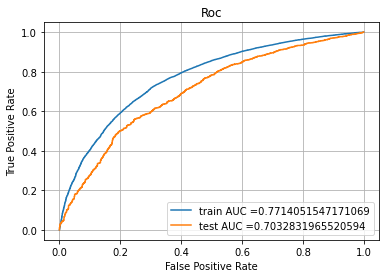

In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


#Best alpha estimates in Hyper param
alpha = 0.5
naive_bag_of_words = MultinomialNB(alpha=alpha)
naive_bag_of_words.fit(X_train_final_data, Y_train_final)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batchPredict(naive_bag_of_words, X_train_final_data)    
y_test_pred = batchPredict(naive_bag_of_words, X_test_final_data)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train_final, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Roc")
plt.grid()
plt.show()

Select The Best Threshold

In [24]:
def find_best_threshold(threshold, fpr, tpr):
    
    #https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_threshold(proba, threshold):
    predictions = [1 if i >= threshold else 0 for i in proba]
    return predictions

# Confusion Matrix 

In [25]:
#SRC : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def confusionMatrixPlot(confusionMatrix,title):
    
    plt.figure(figsize = (8,8))
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusionMatrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         confusionMatrix.flatten()/np.sum(confusionMatrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusionMatrix, annot=labels,fmt='', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

The maximum value of tpr*(1-fpr) 0.5021428275951094 for threshold 0.778


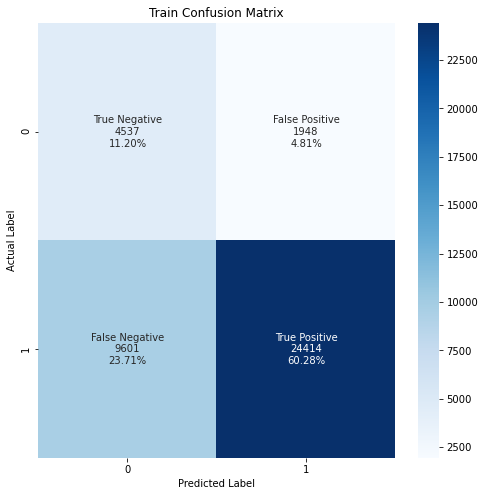

In [26]:
from sklearn.metrics import confusion_matrix

#training threshold,train_false_positive_rate,train_true_positive_rate
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)


y_train_prediction = predict_with_best_threshold(y_train_pred,best_t)

train_confusion_matrix = confusion_matrix(Y_train_final,y_train_prediction)
confusionMatrixPlot(train_confusion_matrix,"Train Confusion Matrix")

Confusion Matrix For Test Data


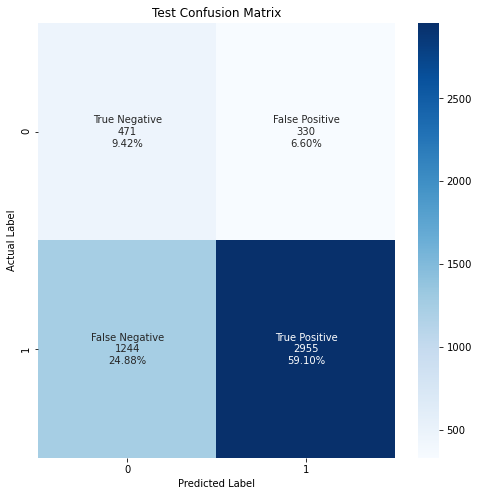

In [27]:
y_test_prediction = predict_with_best_threshold(y_test_pred, best_t)
test_confusion_matrix = confusion_matrix(y_test, y_test_prediction)
print("Confusion Matrix For Test Data")
print("="* 100)
confusionMatrixPlot(test_confusion_matrix,"Test Confusion Matrix")

# Train the Model PreProcess with essay TFIDF

In [28]:
x_train_final.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
2079,md,mrs,grades_prek_2,5,appliedlearning specialneeds,earlydevelopment specialneeds,behavior communication change environment beha...,172.27
42096,ca,ms,grades_prek_2,1,math_science specialneeds,environmentalscience specialneeds,students second third graders special needs in...,115.19
49283,sd,ms,grades_3_5,0,literacy_language math_science,literature_writing mathematics,first year teacher teaching special education ...,149.94
15511,oh,mrs,grades_3_5,2,literacy_language history_civics,literature_writing socialsciences,teach small rural school district district res...,245.61
3469,tx,ms,grades_prek_2,1,literacy_language,esl literacy,reading hard subject kids days much exposure t...,654.46


#  Tfidf Vectorization

In [29]:
#PreProcess the essay a feature with TFIDF Implementation
vectorizer = TfidfVectorizer(max_features = 5000)
vectorizer.fit(x_train_final.essay.values)
print(len(vectorizer.get_feature_names()))
X_train_essay_tfidf = vectorizer.transform(x_train_final.essay.values)
x_cv_essay_tfidf = vectorizer.transform(x_cv.essay.values)
x_test_essay_tfidf = vectorizer.transform(x_test.essay.values)

5000


## Merge  Preprocessed Data

In [30]:

#Training Preprocessing Dataset
X_train_final_data_tfidf = hstack((X_train_essay_tfidf, X_train_teacher_prefix_category, X_train_project_grade_category, \
               X_train_school_state, X_train_clean_categories,X_train_clean_subcategories,\
                 x_train_price_norm,x_train_previous_project_norm)).tocsr()


#Test Prprocessing final Dataset
X_test_final_data_tfidf = hstack((x_test_essay_tfidf, x_test_teacher_prefix_category, x_test_project_grade_category, \
               x_test_teacher_school_state, x_test_clean_categories,x_test_clean_subcategories,\
                 x_test_price_norm,x_test_previous_project_norm)).tocsr()

#Cross Validation Preprocessing Dataset
X_cv_final_data_tfidf = hstack((x_cv_essay_tfidf, x_cv_test_prefix_category, x_cv_project_grade_category, \
               x_cv_school_state, x_cv_clean_categories,x_cv_clean_subcategories,\
                 x_cv_price_norm,x_cv_previous_project_norm)).tocsr()

print("="*100)
print("Ater Encoding and Transforming Numerical and Categorical Features")
print(X_train_final_data_tfidf.shape, Y_train_final.shape)
print(X_test_final_data_tfidf.shape, y_test.shape)
print(X_cv_final_data_tfidf.shape, y_cv.shape)

Ater Encoding and Transforming Numerical and Categorical Features
(40500, 5101) (40500,)
(5000, 5101) (5000,)
(4500, 5101) (4500,)


## Train the Model With Essay Feature as TFIDF Processing

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.54it/s]


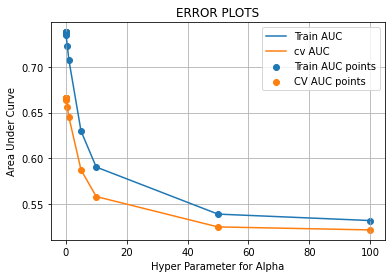

In [31]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

train_auc_ifidf,cv_auc_tfidf = [],[]
#hyper param tuning 
alphaList =  [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
class_weight = [0.5,0.5]
for alpha in tqdm(alphaList):
    naive = MultinomialNB(alpha=alpha,class_prior = class_weight)
    naive.fit(X_train_final_data_tfidf, Y_train_final)

    y_train_pred = batchPredict(naive, X_train_final_data_tfidf)    
    y_cv_pred = batchPredict(naive, X_cv_final_data_tfidf)
    
    train_auc_ifidf.append(roc_auc_score(Y_train_final,y_train_pred))
    cv_auc_tfidf.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alphaList, train_auc_ifidf, label='Train AUC')
plt.plot(alphaList, cv_auc_tfidf, label='cv AUC')

plt.scatter(alphaList, train_auc_ifidf, label='Train AUC points')
plt.scatter(alphaList, cv_auc_tfidf, label='CV AUC points')

plt.legend()
plt.xlabel("Hyper Parameter for Alpha")
plt.ylabel("Area Under Curve")
plt.title("ERROR PLOTS")
plt.grid()
plt.show() 

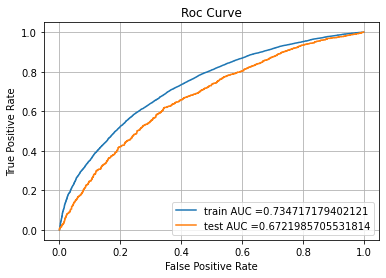

In [32]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

#Best Alpha for TfIDF
best_alpha = 0.1
naive = MultinomialNB(alpha=best_alpha)
naive.fit(X_train_final_data_tfidf, Y_train_final)

y_train_pred = batchPredict(naive, X_train_final_data_tfidf)    
y_test_pred = batchPredict(naive, X_test_final_data_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train_final, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Roc Curve")
plt.grid()
plt.show()

## Confusion Matrix For TFIDF Features


The maximum value of tpr*(1-fpr) 0.45047476106679313 for threshold 0.84


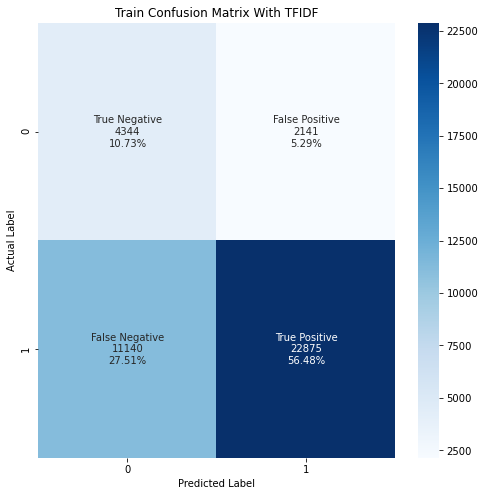

In [33]:
#training threshold,train_false_positive_rate,train_true_positive_rate
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

y_train_prediction = predict_with_best_threshold(y_train_pred,best_t)

train_confusion_matrix = confusion_matrix(Y_train_final,y_train_prediction)
confusionMatrixPlot(train_confusion_matrix,"Train Confusion Matrix With TFIDF")

Confusion Matrix For Test Data


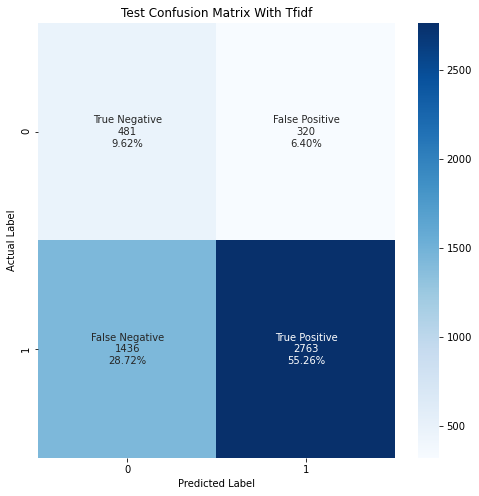

In [34]:
y_test_prediction = predict_with_best_threshold(y_test_pred, best_t)
test_confusion_matrix = confusion_matrix(y_test, y_test_prediction)
print("Confusion Matrix For Test Data")
print("="* 100)
confusionMatrixPlot(test_confusion_matrix,"Test Confusion Matrix With Tfidf")

In [35]:
#Find the Top @0 features 
#argSort the Probability based on sort the Indices
Positive_probability_score = naive_bag_of_words.feature_log_prob_[1].argsort(kind = 'quicksort')
Negative_probability_score = naive_bag_of_words.feature_log_prob_[0].argsort(kind = 'quicksort')

Top_20_positive_probability = Positive_probability_score[-20:]
Top_20_negative_probability = Negative_probability_score[-20:]
#https://www.geeksforgeeks.org/numpy-take-python/
#Take the Feature Based on the Indices
top_positive_features =  np.take(feature_name_List,Top_20_positive_probability)
top_negative_features = np.take(feature_name_List,Top_20_negative_probability)
print("Positive Feature Names :{0}".format(top_positive_features))

print("Nagative Feature Names : {0}".format(top_negative_features))




Positive Feature Names :['year' 'class' 'come' 'teacher_number_of_previously_posted_projects'
 'love' 'able' 'day' 'use' 'need' 'reading' 'work' 'nannan' 'many' 'price'
 'help' 'learn' 'classroom' 'learning' 'school' 'students']
Nagative Feature Names : ['want' 'skills' 'reading' 'teacher_number_of_previously_posted_projects'
 'day' 'able' 'love' 'year' 'come' 'work' 'need' 'nannan' 'many' 'price'
 'help' 'learn' 'classroom' 'learning' 'school' 'students']


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [37]:
#https://www.geeksforgeeks.org/creating-tables-with-prettytable-library-python/
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
table = PrettyTable(["Vectorizer", "Model", "Hyper Parameter - Alpha","Test AUC"])
  
# Add rows
table.add_row(["Bag Of Words", "Naive Bayes", "0.5", "0.70"])
table.add_row(["TFIDF", "Naive Bayes", "0.1", "0.67.2"])

  
print(table)

+--------------+-------------+-------------------------+----------+
|  Vectorizer  |    Model    | Hyper Parameter - Alpha | Test AUC |
+--------------+-------------+-------------------------+----------+
| Bag Of Words | Naive Bayes |           0.5           |   0.70   |
|    TFIDF     | Naive Bayes |           0.1           |  0.67.2  |
+--------------+-------------+-------------------------+----------+
